In [313]:
# %pip install pmdarima
# %pip install pmdarima
# %pip install sktime
# %pip install pandas --upgrade
# %pip install numpy --upgrade



In [272]:
import pandas as pd
import numpy as np
import datetime
import math

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from IPython.display import Image

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
pd.options.plotting.backend = "plotly"
# pd.options.plotting.backend = "matplotlib"

import matplotlib

import warnings
warnings.filterwarnings('ignore')

import scipy as sc
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import joblib

from sktime.forecasting.model_selection import ExpandingWindowSplitter, ForecastingGridSearchCV, temporal_train_test_split
from sktime.forecasting.base import ForecastingHorizon
from sktime.utils.plotting import plot_correlations


from sktime.forecasting.model_selection import SlidingWindowSplitter

import pmdarima
from pmdarima import model_selection
from sktime.forecasting.arima import AutoARIMA, ARIMA
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error, mean_squared_error
from sktime.utils.plotting import plot_series
from sklearn.metrics import r2_score


import warnings

plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (20,5)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)


# Данные

In [273]:
data = pd.read_csv('Custom_location.csv')

In [274]:
data = data.tail(365*3)

In [275]:
data

,dt,dt_iso,timezone,city_name,lat,lon,temp,visibility,dew_point,feels_like,temp_min,temp_max,pressure,sea_level,grnd_level,humidity,wind_speed,wind_deg,wind_gust,rain_1h,rain_3h,snow_1h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
400377,1725354000,2024-09-03 09:00:00 +0000 UTC,10800,Custom location,55.773239,37.580463,25.93,NaN,10.93,25.60,25.82,26.04,1027,NaN,NaN,39,2.41,87,NaN,NaN,NaN,NaN,NaN,0,800,Clear,sky is clear,01d
400378,1725357600,2024-09-03 10:00:00 +0000 UTC,10800,Custom location,55.773239,37.580463,26.73,NaN,9.58,26.41,26.58,26.84,1027,NaN,NaN,34,1.51,78,NaN,NaN,NaN,NaN,NaN,0,800,Clear,sky is clear,01d
400379,1725361200,2024-09-03 11:00:00 +0000 UTC,10800,Custom location,55.773239,37.580463,26.67,NaN,9.08,26.33,26.54,26.77,1026,NaN,NaN,33,1.99,60,NaN,NaN,NaN,NaN,NaN,0,800,Clear,sky is clear,01d
400380,1725364800,2024-09-03 12:00:00 +0000 UTC,10800,Custom location,55.773239,37.580463,26.64,NaN,9.06,26.64,26.52,26.74,1026,NaN,NaN,33,2.42,56,NaN,NaN,NaN,NaN,NaN,0,800,Clear,sky is clear,01d
400381,1725368400,2024-09-03 13:00:00 +0000 UTC,10800,Custom location,55.773239,37.580463,26.68,NaN,9.09,26.34,26.59,26.79,1026,NaN,NaN,33,2.59,56,NaN,NaN,NaN,NaN,NaN,0,800,Clear,sky is clear,01d
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401467,1729278000,2024-10-18 19:00:00 +0000 UTC,10800,Custom location,55.773239,37.580463,3.28,NaN,-0.16,1.41,2.54,3.99,1034,NaN,NaN,78,1.96,49,2.07,NaN,NaN,NaN,NaN,5,800,Clear,sky is clear,01n
401468,1729281600,2024-10-18 20:00:00 +0000 UTC,10800,Custom location,55.773239,37.580463,2.19,NaN,-0.35,0.40,1.65,2.80,1034,NaN,NaN,83,1.75,56,1.87,NaN,NaN,NaN,NaN,6,800,Clear,sky is clear,01n
401469,1729285200,2024-10-18 21:00:00 +0000 UTC,10800,Custom location,55.773239,37.580463,2.19,NaN,-0.35,0.40,1.65,2.80,1034,NaN,NaN,83,1.75,56,1.87,NaN,NaN,NaN,NaN,6,800,Clear,sky is clear,01n
401470,1729288800,2024-10-18 22:00:00 +0000 UTC,10800,Custom location,55.773239,37.580463,2.19,NaN,-0.35,0.40,1.65,2.80,1034,NaN,NaN,83,1.75,56,1.87,NaN,NaN,NaN,NaN,6,800,Clear,sky is clear,01n


In [276]:
data[['pressure']].plot()

### Разбиваем на тренировочную и тестовую выборки

In [277]:
data['datetime'] = data['dt'].apply(datetime.fromtimestamp)

data = data.set_index('datetime')
data.index = data.index.to_period("h")

In [278]:
data

,dt,dt_iso,timezone,city_name,lat,lon,temp,visibility,dew_point,feels_like,temp_min,temp_max,pressure,sea_level,grnd_level,humidity,wind_speed,wind_deg,wind_gust,rain_1h,rain_3h,snow_1h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-09-03 09:00,1725354000,2024-09-03 09:00:00 +0000 UTC,10800,Custom location,55.773239,37.580463,25.93,NaN,10.93,25.60,25.82,26.04,1027,NaN,NaN,39,2.41,87,NaN,NaN,NaN,NaN,NaN,0,800,Clear,sky is clear,01d
2024-09-03 10:00,1725357600,2024-09-03 10:00:00 +0000 UTC,10800,Custom location,55.773239,37.580463,26.73,NaN,9.58,26.41,26.58,26.84,1027,NaN,NaN,34,1.51,78,NaN,NaN,NaN,NaN,NaN,0,800,Clear,sky is clear,01d
2024-09-03 11:00,1725361200,2024-09-03 11:00:00 +0000 UTC,10800,Custom location,55.773239,37.580463,26.67,NaN,9.08,26.33,26.54,26.77,1026,NaN,NaN,33,1.99,60,NaN,NaN,NaN,NaN,NaN,0,800,Clear,sky is clear,01d
2024-09-03 12:00,1725364800,2024-09-03 12:00:00 +0000 UTC,10800,Custom location,55.773239,37.580463,26.64,NaN,9.06,26.64,26.52,26.74,1026,NaN,NaN,33,2.42,56,NaN,NaN,NaN,NaN,NaN,0,800,Clear,sky is clear,01d
2024-09-03 13:00,1725368400,2024-09-03 13:00:00 +0000 UTC,10800,Custom location,55.773239,37.580463,26.68,NaN,9.09,26.34,26.59,26.79,1026,NaN,NaN,33,2.59,56,NaN,NaN,NaN,NaN,NaN,0,800,Clear,sky is clear,01d
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-18 19:00,1729278000,2024-10-18 19:00:00 +0000 UTC,10800,Custom location,55.773239,37.580463,3.28,NaN,-0.16,1.41,2.54,3.99,1034,NaN,NaN,78,1.96,49,2.07,NaN,NaN,NaN,NaN,5,800,Clear,sky is clear,01n
2024-10-18 20:00,1729281600,2024-10-18 20:00:00 +0000 UTC,10800,Custom location,55.773239,37.580463,2.19,NaN,-0.35,0.40,1.65,2.80,1034,NaN,NaN,83,1.75,56,1.87,NaN,NaN,NaN,NaN,6,800,Clear,sky is clear,01n
2024-10-18 21:00,1729285200,2024-10-18 21:00:00 +0000 UTC,10800,Custom location,55.773239,37.580463,2.19,NaN,-0.35,0.40,1.65,2.80,1034,NaN,NaN,83,1.75,56,1.87,NaN,NaN,NaN,NaN,6,800,Clear,sky is clear,01n


In [279]:
test_size = 8

# тренировочная и тестовая выборки
train, test = data[:-test_size], data[-test_size:]

len(train)


1087

In [280]:
fh = ForecastingHorizon(test.index, is_relative=False)

# класс для разбиения выборки на фолды для кросс валидации
cv = ExpandingWindowSplitter(
    # start_with_window=True,
    initial_window=800,
    fh=list(range(1, test_size+1)),
    step_length= 16)

In [281]:
# сколько будет фолдов на тестовой выборке
len(list(cv.split_series(train)))

18

# ARIMA

In [282]:
param_to_predict = 'pressure'

train = train[param_to_predict]

In [283]:
# необходимое значение d
# находится путем проверки стационарности по тренду (тест kpss) при различных значениях d
d = pmdarima.arima.ndiffs(train)
d

1

In [284]:
train_differenced = train.diff().dropna()


(<Figure size 1200x800 with 3 Axes>,
 array([<Axes: ylabel='pressure'>,
        <Axes: title={'center': 'Autocorrelation'}>,
        <Axes: title={'center': 'Partial Autocorrelation'}>], dtype=object))

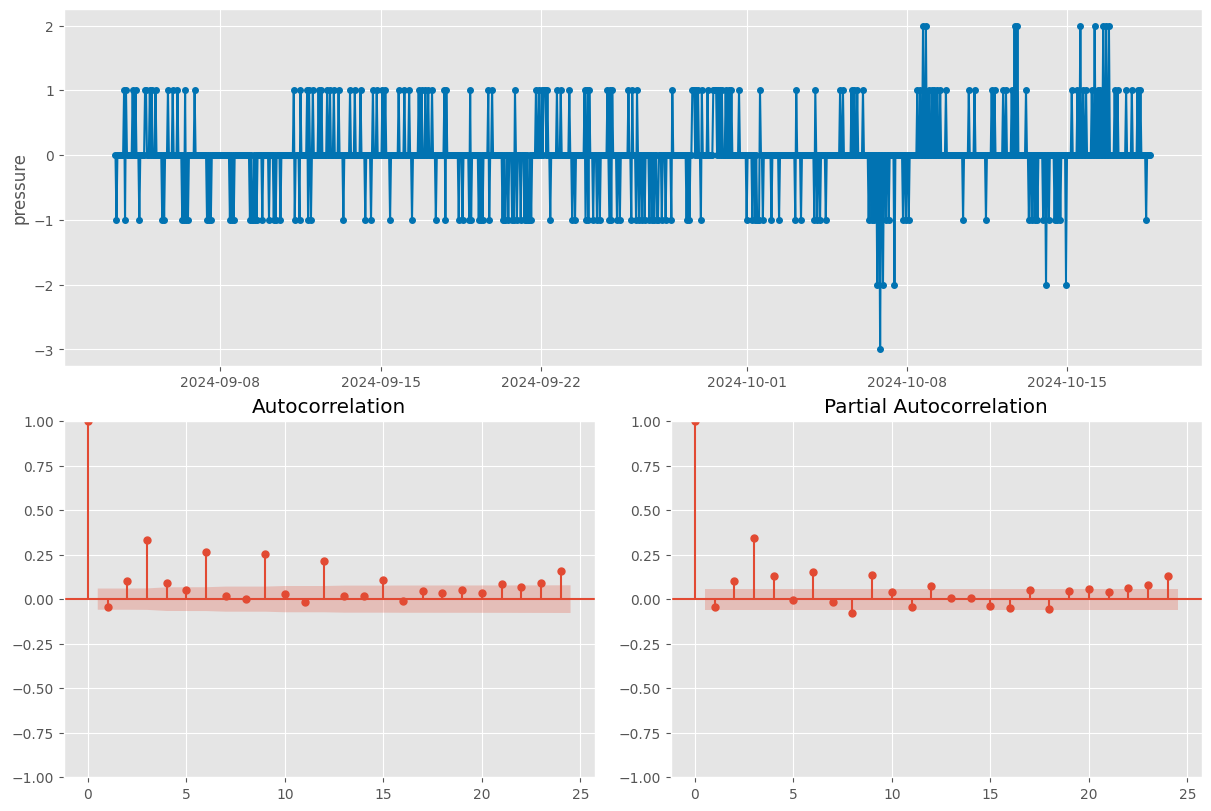

In [285]:
plot_correlations(train_differenced)


In [286]:
# собираем сетку параметров

max_d = 1
max_p = 4
max_q = 4

orders = []
for d in range(1, max_d+1):
    for p in range(1, max_p+1):
        for q in range(1, max_q+1):
            orders.append((p, d, q))

In [287]:
# это лучшая модель
orders = [(6, 1, 6)]

In [288]:
# модель ARIMA
forecaster = ARIMA()

# сетка параметров
param_grid = {"order" : orders, 'enforce_stationarity': [False]}

# отбор модели по кросс-валидации
gscv = ForecastingGridSearchCV(
    forecaster=forecaster,
    param_grid=param_grid,
    cv=cv,
    n_jobs=-1,
    error_score='raise',
    scoring=mean_absolute_percentage_error
    )

gscv.fit(train.dropna())

ForecastingGridSearchCV(cv=ExpandingWindowSplitter(fh=[1, 2, 3, 4, 5, 6, 7, 8],
                                                   initial_window=800,
                                                   step_length=16),
                        error_score='raise', forecaster=ARIMA(), n_jobs=-1,
                        param_grid={'enforce_stationarity': [False],
                                    'order': [(6, 1, 6)]},
                        scoring=<function mean_absolute_percentage_error at 0x7e41d9debb50>)

In [289]:
# результат лучшей модели
gscv.best_score_

0.0013074559150908123

In [290]:
# лучшая модель
gscv.best_forecaster_.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1087
Model:               SARIMAX(6, 1, 6)   Log Likelihood                -740.228
Date:                Tue, 10 Dec 2024   AIC                           1508.456
Time:                        17:44:49   BIC                           1578.230
Sample:                    09-03-2024   HQIC                          1534.877
                         - 10-18-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0067      0.027      0.246      0.805      -0.046       0.060
ar.L1         -0.4554      0.214     -2.126      0.034      -0.875      -0.036
ar.L2         -0.7055      0.175     -4.020      0.000      -1.049      -0.362
ar.L3          0.4476      0.194      2.313      0.021       0.068       0.827
ar.L4          0.2597      0.185      1.400      0.161      -0.104       0.623
ar.L5          0.4579      0.156      2.943      0.003       0.153       0.763
ar.L6          0.1525      0.160      0.952      0.341      -0.161       0.466
ma.L1          0.3511      0.210      1.672      0.094      -0.060       0.763
ma.L2          0.7693      0.174      4.421      0.000       0.428       1.110
ma.L3         -0.2323      0.202     -1.149      0.251      -0.629       0.164
ma.L4          0.0636      0.152      0.418      0.676      -0.235       0.362
ma.L5         -0.2025      0.126     -1.604      0.109      -0.450       0.045
ma.L6          0.0865      0.133      0.652      0.514      -0.173       0.346
sigma2         0.2288      0.008     29.713      0.000       0.214       0.244
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               145.59
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.05   Skew:                            -0.09
Prob(H) (two-sided):                  0.62   Kurtosis:                         4.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [291]:
y_pred = gscv.best_forecaster_.predict(fh)

# значение mape и rmse на тестовой выборке
(mean_absolute_percentage_error(test[param_to_predict], y_pred),
mean_squared_error(test[param_to_predict], y_pred, square_root=True),
 r2_score(test[param_to_predict], y_pred))



(0.00019106861359474296, 0.20730031370906438, 0.0)

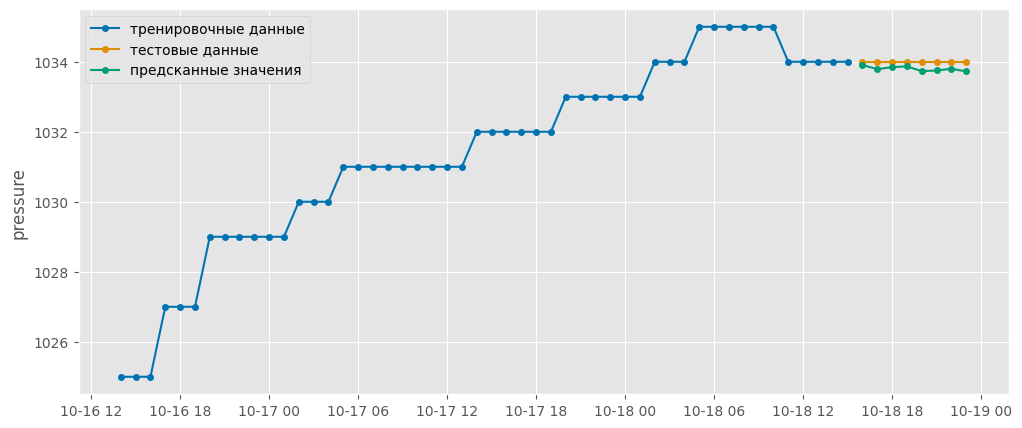

In [292]:
# график предсказанных и фактических значений
fig, ax = plot_series(train[-50:], test[param_to_predict], y_pred, labels=["тренировочные данные", "тестовые данные", "предсканные значения"])
ax.legend(loc='upper left')
ax.figure.set_size_inches(12, 5)

In [293]:
def give_cv_results(data, model):

    result = pd.DataFrame(columns=['train_from','train_to','test_from','test_to','mape','rmse', 'r2'])

    for window in data:
        cv_train = window[0]
        cv_test = window[1]

        model.fit(cv_train)

        fh = ForecastingHorizon(cv_test.index, is_relative=False)
        cv_pred = model.predict(fh)

        cv_mape = mean_absolute_percentage_error(cv_test, cv_pred)
        cv_rmse = mean_squared_error(cv_test, cv_pred, square_root=True)
        cv_r2 = r2_score(cv_test, cv_pred)

        result.loc[len(result)] = [cv_train.index[0], cv_train.index[-1], cv_test.index[0], cv_test.index[-1], cv_mape, cv_rmse, cv_r2]

    return result

In [294]:
arima_cv_results = give_cv_results(cv.split_series(train), gscv.best_forecaster_)

In [295]:
arima_cv_results

,train_from,train_to,test_from,test_to,mape,rmse,r2
0,2024-09-03 09:00,2024-10-06 16:00,2024-10-06 17:00,2024-10-07 00:00,0.003735,4.196442,-3.419797
1,2024-09-03 09:00,2024-10-07 08:00,2024-10-07 09:00,2024-10-07 16:00,0.001323,1.511475,-2.046074
2,2024-09-03 09:00,2024-10-08 00:00,2024-10-08 01:00,2024-10-08 08:00,0.000212,0.277394,0.296483
3,2024-09-03 09:00,2024-10-08 16:00,2024-10-08 17:00,2024-10-09 00:00,0.002908,3.126272,-5.515717
4,2024-09-03 09:00,2024-10-09 08:00,2024-10-09 09:00,2024-10-09 16:00,0.000200,0.276227,0.593059
5,2024-09-03 09:00,2024-10-10 00:00,2024-10-10 01:00,2024-10-10 08:00,0.000086,0.092914,0.000000
6,2024-09-03 09:00,2024-10-10 16:00,2024-10-10 17:00,2024-10-11 00:00,0.001382,1.478383,-10.656619
7,2024-09-03 09:00,2024-10-11 08:00,2024-10-11 09:00,2024-10-11 16:00,0.000692,0.805101,-2.457004
8,2024-09-03 09:00,2024-10-12 00:00,2024-10-12 01:00,2024-10-12 08:00,0.000596,0.857323,-0.517425
9,2024-09-03 09:00,2024-10-12 16:00,2024-10-12 17:00,2024-10-13 00:00,0.002547,2.726126,-6.927215


# ETS

In [296]:
from sktime.forecasting.ets import AutoETS
ets_forecaster = AutoETS()

ets_forecaster.fit(train)



AutoETS()

In [297]:
y_pred = ets_forecaster.predict(fh = fh)

# значение mape и rmse на тестовой выборке
(mean_absolute_percentage_error(test[param_to_predict], y_pred),
mean_squared_error(test[param_to_predict], y_pred, square_root=True),
 r2_score(test[param_to_predict], y_pred))

(4.4759189692232215e-11, 4.628100214176811e-08, 0.0)

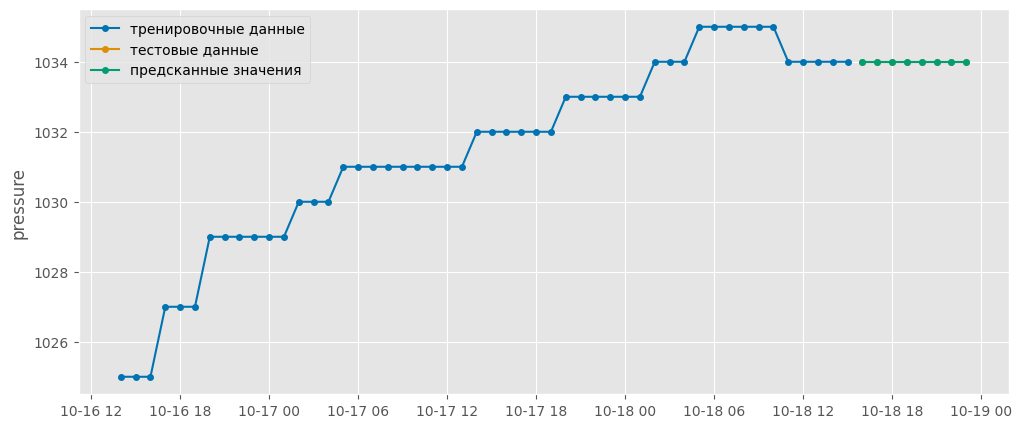

In [298]:
# график предсказанных и фактических значений
fig, ax = plot_series(train[-50:], test[param_to_predict], y_pred, labels=["тренировочные данные", "тестовые данные", "предсканные значения"])
ax.legend(loc='upper left')
ax.figure.set_size_inches(12, 5)

In [299]:
ets_cv_results = give_cv_results(cv.split_series(train), ets_forecaster)

In [300]:
ets_cv_results

,train_from,train_to,test_from,test_to,mape,rmse,r2
0,2024-09-03 09:00,2024-10-06 16:00,2024-10-06 17:00,2024-10-07 00:00,4.324474e-03,4.808954e+00,-4.804183
1,2024-09-03 09:00,2024-10-07 08:00,2024-10-07 09:00,2024-10-07 16:00,1.491058e-03,1.732055e+00,-3.000017
2,2024-09-03 09:00,2024-10-08 00:00,2024-10-08 01:00,2024-10-08 08:00,8.743697e-04,9.372790e-01,-7.031926
3,2024-09-03 09:00,2024-10-08 16:00,2024-10-08 17:00,2024-10-09 00:00,3.469116e-03,3.708181e+00,-8.167069
4,2024-09-03 09:00,2024-10-09 08:00,2024-10-09 09:00,2024-10-09 16:00,7.814807e-04,9.030034e-01,-3.348881
5,2024-09-03 09:00,2024-10-10 00:00,2024-10-10 01:00,2024-10-10 08:00,9.520573e-15,9.663381e-12,0.000000
6,2024-09-03 09:00,2024-10-10 16:00,2024-10-10 17:00,2024-10-11 00:00,1.231042e-03,1.322876e+00,-8.333333
7,2024-09-03 09:00,2024-10-11 08:00,2024-10-11 09:00,2024-10-11 16:00,7.389163e-04,8.660254e-01,-3.000000
8,2024-09-03 09:00,2024-10-12 00:00,2024-10-12 01:00,2024-10-12 08:00,6.137080e-04,9.354144e-01,-0.806452
9,2024-09-03 09:00,2024-10-12 16:00,2024-10-12 17:00,2024-10-13 00:00,3.175328e-03,3.391230e+00,-11.267138


# Наивный прогноз

In [301]:

def naive_forecast(df, indexes):

    last_value = df.iloc[-1]

    # Создаем прогноз, повторяя последнее значение
    forecast_values = [last_value] * len(indexes)


    # Создаем pd.Series для прогноза
    forecast_series = pd.Series(data=forecast_values, index=indexes, name='pressure')

    return forecast_series

# Пример использования:
# df = pd.DataFrame(..., columns=['pressure'], index=pd.to_datetime(...))
# forecast = naive_forecast(df, steps=5)
# print(forecast)

In [302]:
y_pred = naive_forecast(train, test.index)

# значение mape и rmse на тестовой выборке
(mean_absolute_percentage_error(test[param_to_predict], y_pred),
mean_squared_error(test[param_to_predict], y_pred, square_root=True),
 r2_score(test[param_to_predict], y_pred))

(0.0, 0.0, 1.0)

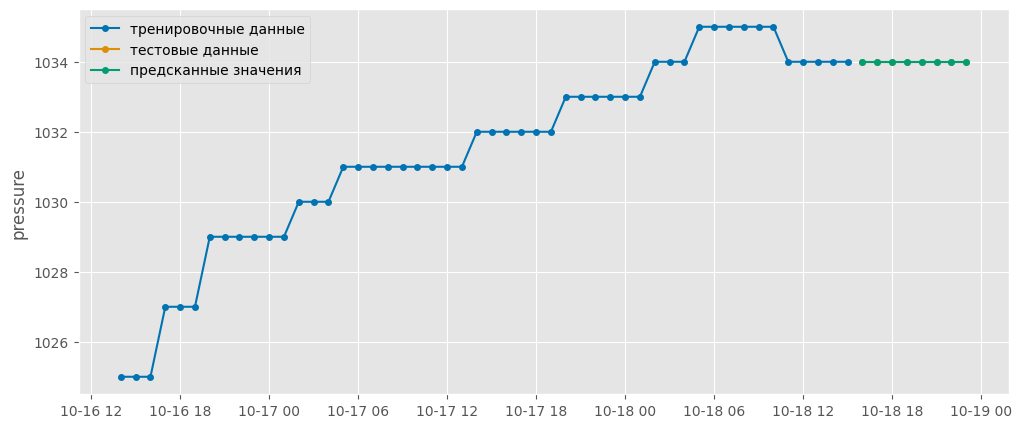

In [303]:
# график предсказанных и фактических значений
fig, ax = plot_series(train[-50:], test[param_to_predict], y_pred, labels=["тренировочные данные", "тестовые данные", "предсканные значения"])
ax.legend(loc='upper left')
ax.figure.set_size_inches(12, 5)

In [304]:
def give_cv_naive_results(data):

    result = pd.DataFrame(columns=['train_from','train_to','test_from','test_to','mape','rmse', 'r2'])

    for window in data:
        cv_train = window[0]
        cv_test = window[1]

        cv_pred = naive_forecast(cv_train, cv_test.index)

        cv_mape = mean_absolute_percentage_error(cv_test, cv_pred)
        cv_rmse = mean_squared_error(cv_test, cv_pred, square_root=True)
        cv_r2 = r2_score(cv_test, cv_pred)

        result.loc[len(result)] = [cv_train.index[0], cv_train.index[-1], cv_test.index[0], cv_test.index[-1], cv_mape, cv_rmse, cv_r2]

    return result

In [305]:
naive_cv_results = give_cv_naive_results(cv.split_series(train))

In [306]:
naive_cv_results

,train_from,train_to,test_from,test_to,mape,rmse,r2
0,2024-09-03 09:00,2024-10-06 16:00,2024-10-06 17:00,2024-10-07 00:00,0.004324,4.808846,-4.803922
1,2024-09-03 09:00,2024-10-07 08:00,2024-10-07 09:00,2024-10-07 16:00,0.001491,1.732051,-3.000000
2,2024-09-03 09:00,2024-10-08 00:00,2024-10-08 01:00,2024-10-08 08:00,0.000872,0.935414,-7.000000
3,2024-09-03 09:00,2024-10-08 16:00,2024-10-08 17:00,2024-10-09 00:00,0.003469,3.708099,-8.166667
4,2024-09-03 09:00,2024-10-09 08:00,2024-10-09 09:00,2024-10-09 16:00,0.000740,0.866025,-3.000000
5,2024-09-03 09:00,2024-10-10 00:00,2024-10-10 01:00,2024-10-10 08:00,0.000000,0.000000,1.000000
6,2024-09-03 09:00,2024-10-10 16:00,2024-10-10 17:00,2024-10-11 00:00,0.001231,1.322876,-8.333333
7,2024-09-03 09:00,2024-10-11 08:00,2024-10-11 09:00,2024-10-11 16:00,0.000739,0.866025,-3.000000
8,2024-09-03 09:00,2024-10-12 00:00,2024-10-12 01:00,2024-10-12 08:00,0.000614,0.935414,-0.806452
9,2024-09-03 09:00,2024-10-12 16:00,2024-10-12 17:00,2024-10-13 00:00,0.003175,3.391165,-11.266667


# Сравнение моделей

### Результаты CV всех моделей

In [307]:
arima_cv_results

,train_from,train_to,test_from,test_to,mape,rmse,r2
0,2024-09-03 09:00,2024-10-06 16:00,2024-10-06 17:00,2024-10-07 00:00,0.003735,4.196442,-3.419797
1,2024-09-03 09:00,2024-10-07 08:00,2024-10-07 09:00,2024-10-07 16:00,0.001323,1.511475,-2.046074
2,2024-09-03 09:00,2024-10-08 00:00,2024-10-08 01:00,2024-10-08 08:00,0.000212,0.277394,0.296483
3,2024-09-03 09:00,2024-10-08 16:00,2024-10-08 17:00,2024-10-09 00:00,0.002908,3.126272,-5.515717
4,2024-09-03 09:00,2024-10-09 08:00,2024-10-09 09:00,2024-10-09 16:00,0.000200,0.276227,0.593059
5,2024-09-03 09:00,2024-10-10 00:00,2024-10-10 01:00,2024-10-10 08:00,0.000086,0.092914,0.000000
6,2024-09-03 09:00,2024-10-10 16:00,2024-10-10 17:00,2024-10-11 00:00,0.001382,1.478383,-10.656619
7,2024-09-03 09:00,2024-10-11 08:00,2024-10-11 09:00,2024-10-11 16:00,0.000692,0.805101,-2.457004
8,2024-09-03 09:00,2024-10-12 00:00,2024-10-12 01:00,2024-10-12 08:00,0.000596,0.857323,-0.517425
9,2024-09-03 09:00,2024-10-12 16:00,2024-10-12 17:00,2024-10-13 00:00,0.002547,2.726126,-6.927215


In [308]:
ets_cv_results

,train_from,train_to,test_from,test_to,mape,rmse,r2
0,2024-09-03 09:00,2024-10-06 16:00,2024-10-06 17:00,2024-10-07 00:00,4.324474e-03,4.808954e+00,-4.804183
1,2024-09-03 09:00,2024-10-07 08:00,2024-10-07 09:00,2024-10-07 16:00,1.491058e-03,1.732055e+00,-3.000017
2,2024-09-03 09:00,2024-10-08 00:00,2024-10-08 01:00,2024-10-08 08:00,8.743697e-04,9.372790e-01,-7.031926
3,2024-09-03 09:00,2024-10-08 16:00,2024-10-08 17:00,2024-10-09 00:00,3.469116e-03,3.708181e+00,-8.167069
4,2024-09-03 09:00,2024-10-09 08:00,2024-10-09 09:00,2024-10-09 16:00,7.814807e-04,9.030034e-01,-3.348881
5,2024-09-03 09:00,2024-10-10 00:00,2024-10-10 01:00,2024-10-10 08:00,9.520573e-15,9.663381e-12,0.000000
6,2024-09-03 09:00,2024-10-10 16:00,2024-10-10 17:00,2024-10-11 00:00,1.231042e-03,1.322876e+00,-8.333333
7,2024-09-03 09:00,2024-10-11 08:00,2024-10-11 09:00,2024-10-11 16:00,7.389163e-04,8.660254e-01,-3.000000
8,2024-09-03 09:00,2024-10-12 00:00,2024-10-12 01:00,2024-10-12 08:00,6.137080e-04,9.354144e-01,-0.806452
9,2024-09-03 09:00,2024-10-12 16:00,2024-10-12 17:00,2024-10-13 00:00,3.175328e-03,3.391230e+00,-11.267138


In [309]:
naive_cv_results

,train_from,train_to,test_from,test_to,mape,rmse,r2
0,2024-09-03 09:00,2024-10-06 16:00,2024-10-06 17:00,2024-10-07 00:00,0.004324,4.808846,-4.803922
1,2024-09-03 09:00,2024-10-07 08:00,2024-10-07 09:00,2024-10-07 16:00,0.001491,1.732051,-3.000000
2,2024-09-03 09:00,2024-10-08 00:00,2024-10-08 01:00,2024-10-08 08:00,0.000872,0.935414,-7.000000
3,2024-09-03 09:00,2024-10-08 16:00,2024-10-08 17:00,2024-10-09 00:00,0.003469,3.708099,-8.166667
4,2024-09-03 09:00,2024-10-09 08:00,2024-10-09 09:00,2024-10-09 16:00,0.000740,0.866025,-3.000000
5,2024-09-03 09:00,2024-10-10 00:00,2024-10-10 01:00,2024-10-10 08:00,0.000000,0.000000,1.000000
6,2024-09-03 09:00,2024-10-10 16:00,2024-10-10 17:00,2024-10-11 00:00,0.001231,1.322876,-8.333333
7,2024-09-03 09:00,2024-10-11 08:00,2024-10-11 09:00,2024-10-11 16:00,0.000739,0.866025,-3.000000
8,2024-09-03 09:00,2024-10-12 00:00,2024-10-12 01:00,2024-10-12 08:00,0.000614,0.935414,-0.806452
9,2024-09-03 09:00,2024-10-12 16:00,2024-10-12 17:00,2024-10-13 00:00,0.003175,3.391165,-11.266667


### Средние значения метрик

In [310]:
print('arima results')
arima_cv_results[['mape', 'rmse', 'r2']].mean()

arima results


,0
mape,0.001309
rmse,1.503185
r2,-2.410678


In [311]:
print('ets results')
ets_cv_results[['mape', 'rmse', 'r2']].mean()

ets results


,0
mape,0.001657
rmse,1.892733
r2,-4.441590


In [312]:
print('naive results')
naive_cv_results[['mape', 'rmse', 'r2']].mean()

naive results


,0
mape,0.001652
rmse,1.888656
r2,-4.356087


### Выводы

При прогнозировании на 24 часа вперед самой эффективной моделью оказалась arima. У нее наименьшие метрики mape, rmse, r2

---

**arima results**

mape	0.002915
rmse	3.399897
r2	-3.042466

**ets results**

mape	0.003383
rmse	3.870730
r2	-4.632148

**naive results**

mape	0.003378
rmse	3.866114
r2	-4.607602

При прогнозировании на 8 часов вперед самой эффективной моделью оказалась arima. У нее наименьшие метрики mape, rmse, r2

---

**arima results**

mape	0.001309
rmse	1.503185
r2	-2.410678


**ets results**

mape	0.001657
rmse	1.892733
r2	-4.441590

**naive results**

mape	0.001652
rmse	1.888656
r2	-4.356087